<a href="https://colab.research.google.com/github/justinnguyendsa/Portfolio/blob/main/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

import timeit

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Data

In [2]:
!gdown 1d1JtwmFdEG1hmBg6FH-hjn1fovxB9W4r

Downloading...
From: https://drive.google.com/uc?id=1d1JtwmFdEG1hmBg6FH-hjn1fovxB9W4r
To: /content/data.csv
100% 562k/562k [00:00<00:00, 14.7MB/s]


In [3]:
df = pd.read_csv('/content/data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
# drop columns
df.drop(columns=['customer_id'], inplace=True)

# EDA

In [8]:
# check data imbalance
df['churn'].value_counts()

,count
churn,
0,7963
1,2037


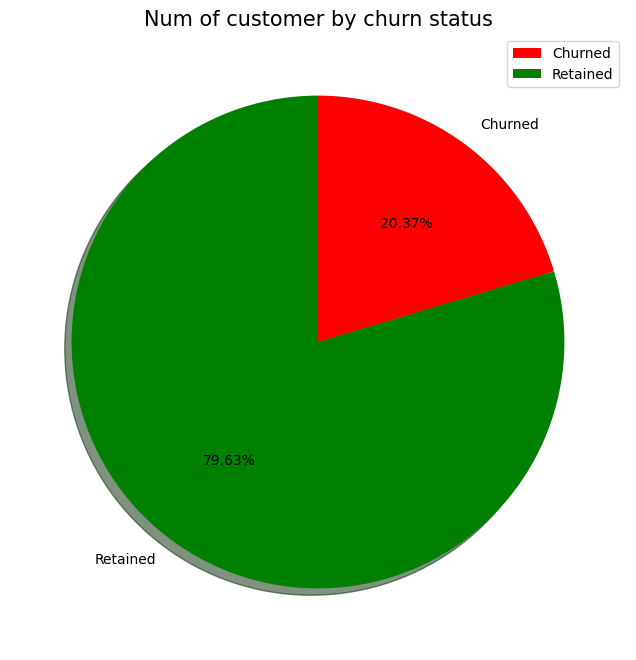

In [13]:
# pie chart for 'churn'
size = [df.churn[df['churn'] == 1].count(), df.churn[df['churn'] == 0].count()]
labels = ['Churned', 'Retained']
figure, axes = plt.subplots(figsize=(10, 8))
axes.pie(size, labels=labels, colors=['red', 'green'], startangle=90, counterclock=False, shadow=True, autopct = '%1.2f%%')
plt.legend()
plt.title("Num of customer by churn status", size = 15)
plt.show()

In [14]:
# churn grouped by active member
px.histogram(df, x = 'active_member', color = 'churn', barmode = 'group')

In [15]:
# churn grouped by active member
px.histogram(df, x = 'country', color = 'churn', barmode = 'group')

In [16]:
# churn grouped by credit card
px.histogram(df, x = 'credit_card', color = 'churn', barmode = 'group')

In [17]:
# churn grouped by gender
px.histogram(df, x = 'gender', color = 'churn', barmode = 'group')

<Axes: >

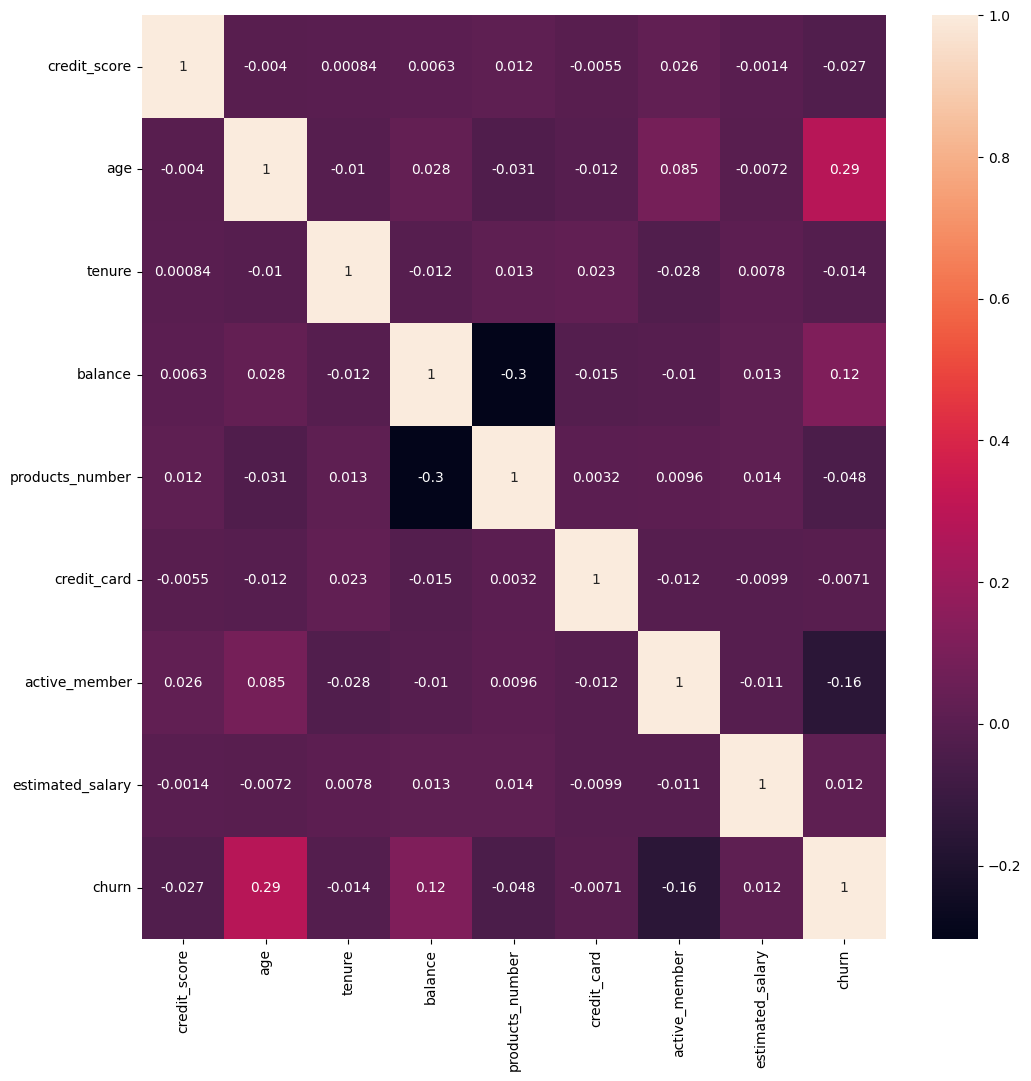

In [18]:
# correlation
plt.figure(figsize=(12,12))
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot=True)

# Data Processing

## Features Scaling

In [19]:
df_scaled_features = df.copy()

In [20]:
col_names = ['balance', 'estimated_salary']
features = df_scaled_features[col_names]
features

,balance,estimated_salary
0,0.00,101348.88
1,83807.86,112542.58
2,159660.80,113931.57
3,0.00,93826.63
4,125510.82,79084.10
...,...,...
9995,0.00,96270.64
9996,57369.61,101699.77
9997,0.00,42085.58
9998,75075.31,92888.52


In [21]:
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
features

array([[-1.22584767,  0.02188649],
       [ 0.11735002,  0.21653375],
       [ 1.33305335,  0.2406869 ],
       ...,
       [-1.22584767, -1.00864308],
       [-0.02260751, -0.12523071],
       [ 0.85996499, -1.07636976]])

In [22]:
df_scaled_features[col_names] = features
df_scaled_features.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,-1.225848,1,1,1,0.021886,1
1,608,Spain,Female,41,1,0.117350,1,0,1,0.216534,0
2,502,France,Female,42,8,1.333053,3,1,0,0.240687,1
3,699,France,Female,39,1,-1.225848,2,0,0,-0.108918,0
4,850,Spain,Female,43,2,0.785728,1,1,1,-0.365276,0


## Get dummies and Convert data

In [28]:
df_scaled_features = pd.get_dummies(df_scaled_features, columns=["country"], drop_first=False)
df_scaled_features.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain
0,619,Female,42,2,-1.225848,1,1,1,0.021886,1,True,False,False
1,608,Female,41,1,0.117350,1,0,1,0.216534,0,False,False,True
2,502,Female,42,8,1.333053,3,1,0,0.240687,1,True,False,False
3,699,Female,39,1,-1.225848,2,0,0,-0.108918,0,True,False,False
4,850,Female,43,2,0.785728,1,1,1,-0.365276,0,False,False,True


In [29]:
# convert categorical variables to numeric representations
df_scaled_features['gender'] = df_scaled_features['gender'].map({'Male':0, 'Female':1})
df_scaled_features.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain
0,619,1,42,2,-1.225848,1,1,1,0.021886,1,True,False,False
1,608,1,41,1,0.117350,1,0,1,0.216534,0,False,False,True
2,502,1,42,8,1.333053,3,1,0,0.240687,1,True,False,False
3,699,1,39,1,-1.225848,2,0,0,-0.108918,0,True,False,False
4,850,1,43,2,0.785728,1,1,1,-0.365276,0,False,False,True


## Split data

In [30]:
# X, y
X = df_scaled_features.drop(columns=['churn'])
y = df_scaled_features['churn']

In [31]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [32]:
# summarize the new class distribution
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 5972, 1: 1528})
Counter({0: 1991, 1: 509})


In [33]:
# transform the dataset
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

#count y
Counter(y_train_smote)

Counter({0: 5972, 1: 5972})

# Logistic Regression

In [34]:
# fit logistic regression
logres = LogisticRegression(C=3, solver='liblinear')
logres.fit(X_train, y_train)

LogisticRegression(C=3, solver='liblinear')

In [35]:
y_pred_log = logres.predict(X_test)
# confusion matrix
print(confusion_matrix(y_pred_log, y_test))
print(classification_report(y_pred_log, y_test))

[[1920  409]
 [  71  100]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.89      2329
           1       0.20      0.58      0.29       171

    accuracy                           0.81      2500
   macro avg       0.58      0.70      0.59      2500
weighted avg       0.91      0.81      0.85      2500



In [36]:
# logistic accuracy
print('Accuracy: ', accuracy_score(y_pred_log, y_test))

Accuracy:  0.808


In [37]:
# Try different c
logr = LogisticRegression()
for c in [1, 3, 10, 50, 100]:
  logr = LogisticRegression(C=c, solver='liblinear')
  model_loggrid = logr.fit(X_train, y_train)

  # accuracy
  y_pred_log = logr.predict(X_test)
  print(f'C = {c}, Accuracy = {accuracy_score(y_pred_log, y_test)}')

C = 1, Accuracy = 0.8068
C = 3, Accuracy = 0.808
C = 10, Accuracy = 0.808
C = 50, Accuracy = 0.808
C = 100, Accuracy = 0.8076


# Decision Tree

In [44]:
criterion = ['gini', 'entropy', 'log_loss']  # different criterion
for c in criterion:
  # Fit Decision Tree classifer
  clf = DecisionTreeClassifier(criterion=c)
  clf = clf.fit(X_train_smote, y_train_smote)
  y_pred_tree = clf.predict(X_test)

  # Accuracy
  print(c)
  print('Accuracy: ', accuracy_score(y_pred_tree, y_test))

  # confusion matrix
  print(confusion_matrix(y_pred_tree, y_test))
  print(classification_report(y_pred_tree, y_test))

gini
Accuracy:  0.7636
[[1646  246]
 [ 345  263]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1892
           1       0.52      0.43      0.47       608

    accuracy                           0.76      2500
   macro avg       0.67      0.65      0.66      2500
weighted avg       0.75      0.76      0.76      2500

entropy
Accuracy:  0.7788
[[1667  229]
 [ 324  280]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1896
           1       0.55      0.46      0.50       604

    accuracy                           0.78      2500
   macro avg       0.69      0.67      0.68      2500
weighted avg       0.77      0.78      0.77      2500

log_loss
Accuracy:  0.7728
[[1655  232]
 [ 336  277]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1887
           1       0.54      0.45      0.49       613

    accuracy             

# Random Forest

In [39]:
# Random Forest
rf = RandomForestClassifier()

In [40]:
# Grid Search
grid_space = {
    'max_depth': [3, 5],
    'n_estimators': [10, 20, 30]
}
rf_grid = GridSearchCV(rf, param_grid=grid_space, scoring='accuracy')
model_grid = rf_grid.fit(X_train_smote, y_train_smote)

In [41]:
# Random Forest accuracy
y_pred_rf = rf_grid.predict(X_test)
print('Accuracy: ', accuracy_score(y_pred_rf, y_test))

Accuracy:  0.798


In [42]:
# Best hyperparameters
print(f'Best hyperparameters: {model_grid.best_params_}')
print(f'Best score: {model_grid.best_score_}')

Best hyperparameters: {'max_depth': 5, 'n_estimators': 30}
Best score: 0.8297920466010812


# KNN

In [49]:
# KNN
knn_pipeline = Pipeline(
    steps=[("classifier", KNeighborsClassifier())]
)

knn_pipeline.fit(X_train_smote, y_train_smote)
knn_pipeline

Pipeline(steps=[('classifier', KNeighborsClassifier())])

In [50]:
# KNN accuracy
y_pred_knn = knn_pipeline.predict(X_test)
print('Accuracy: ', accuracy_score(y_pred_knn, y_test))

Accuracy:  0.6668


# SVC

In [47]:
# SVC
svc_pipeline = Pipeline(
    steps=[("classifier", SVC(probability=True))]  # avoid 'predict_proba is not available when probability=False'
)

svc_pipeline.fit(X_train_smote, y_train_smote)
svc_pipeline

Pipeline(steps=[('classifier', SVC(probability=True))])

In [48]:
# SVC accuracy
y_pred_svc = svc_pipeline.predict(X_test)
print('Accuracy: ', accuracy_score(y_pred_svc, y_test))

Accuracy:  0.7292
